In [3]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
import time
warnings.filterwarnings('ignore')
np.random.seed(4950)

ImportError: DLL load failed: The specified module could not be found.

In [2]:
df_train=pd.read_csv('train_wang.csv')
df_test=pd.read_csv('test_wang.csv')

In [4]:
exclude_features = []
exclude_features += ['card_id', 'first_active_month','target','outliers']
df_train_columns = [c for c in df_train.columns if c not in exclude_features ]
target = df_train['target']
# del df_train['target']

In [5]:
len(df_train_columns)

265

In [10]:
# extra feats
df_extra=pd.read_csv('extra_features.csv')
df_train_extra=df_train.merge(df_extra,on='card_id',how='left')
df_test_extra=df_test.merge(df_extra,on='card_id',how='left')
exclude_features = []
exclude_features += ['card_id', 'first_active_month','target','outliers']
df_train_columns_extra = [c for c in df_train_extra.columns if c not in exclude_features ]

In [6]:
# original Wang's parameters but 'nthread' set to 0 meaning default values
param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 0,
         "random_state": 4950}

In [7]:
from sklearn.model_selection import StratifiedKFold

In [9]:
trn_data = lgb.Dataset(df_train[df_train_columns], label=target)
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4950).split(df_train[df_train_columns],df_train.outliers)
lgb_cv = lgb.cv(param, trn_data, 10000, stratified=False, early_stopping_rounds=600, verbose_eval=200,folds=folds)
print(f'best cv score: {lgb_cv["rmse-mean"][-1]}\nbest boost nums: {len(lgb_cv["rmse-mean"])}')
clf = lgb.train(param, trn_data, len(lgb_cv['rmse-mean']), valid_sets=(trn_data), verbose_eval=200)

[200]	cv_agg's rmse: 3.67909 + 0.00808459
[400]	cv_agg's rmse: 3.65861 + 0.0103467
[600]	cv_agg's rmse: 3.651 + 0.0114004
[800]	cv_agg's rmse: 3.64812 + 0.0120389
[1000]	cv_agg's rmse: 3.64671 + 0.0124638
[1200]	cv_agg's rmse: 3.64634 + 0.0131356
[1400]	cv_agg's rmse: 3.64625 + 0.0134757
[1600]	cv_agg's rmse: 3.64627 + 0.0139156
[1800]	cv_agg's rmse: 3.64642 + 0.0139837
best cv score: 3.6460813379096484
best boost nums: 1266
[200]	training's rmse: 3.57317
[400]	training's rmse: 3.48556
[600]	training's rmse: 3.42968
[800]	training's rmse: 3.38587
[1000]	training's rmse: 3.349
[1200]	training's rmse: 3.31686


In [11]:
# Optimized parameter
param_opt={'bagging_fraction': 0.979,
 'bagging_freq': 1,
 'bagging_seed': 42,
 'boosting': 'gbdt',
 'feature_fraction': 0.503,
 'lambda_l1': 3.96,
 'lambda_l2': 5.7,
 'learning_rate': 0.01,
 'max_depth': 7,
 'metric': 'rmse',
 'min_child_samples': 20,
 'min_data_in_leaf': 31,
 'nthread': 0,
 'num_leaves': 55,
 'objective': 'regression',
 'random_state': 4950,
 'verbosity': -1,
 'device':'gpu',
 'gpu_use_dp':True}

In [12]:
import matplotlib.gridspec as gridspec
import seaborn as sns

In [13]:
# Correlation scores from feature elimination
correlation_scores=pd.read_csv('correlation_score_wangs.csv')
# feature Elimination results
feature_elim_results=pd.read_csv('feature_elim_results_wangs.csv')

In [14]:
feature_elim_results

,num_boost,rmse,threshold
0,1088,3.643191,0
1,1025,3.640097,10
2,1139,3.639745,20
3,1139,3.639505,30
4,1136,3.638330,40
5,1132,3.639430,50
6,1053,3.640391,60
7,1022,3.639406,70
8,1156,3.638599,80
9,1034,3.638943,90


In [21]:
correlation_scores.columns

Index(['0', '1', '2'], dtype='object')

In [27]:
for threshold in [ 0,10,20,30,40,50,60, 70,80, 90, 95, 99]:
    split_feats = correlation_scores[correlation_scores['1']>=threshold]['0'].tolist()

In [31]:
len(split_feats)

38

In [32]:
def lgb_oof(param, data,features,test,verbose=200):
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4950)
    oof = np.zeros(data.shape[0])
    predictions=np.zeros(test.shape[0])
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(data[features], data.outliers)):
        print(f'fold: {fold_}')
        trn_data = lgb.Dataset(data[features].iloc[trn_idx], label=target.iloc[trn_idx])
        val_data = lgb.Dataset(data[features].iloc[val_idx], label=target.iloc[val_idx])
        clf = lgb.train(param, trn_data, 10000, valid_sets=[trn_data, val_data], verbose_eval=verbose, early_stopping_rounds=400)
        oof[val_idx] = clf.predict(data[features].iloc[val_idx], num_iteration=clf.best_iteration)
        predictions+=clf.predict(test[features],num_iteration=clf.best_iteration)/folds.n_splits
        
        del clf, trn_idx, val_idx
        gc.collect()
    print("CV error:"+str(mean_squared_error(target, oof)**0.5))
    return predictions,oof,mean_squared_error(target, oof)**0.5

In [ ]:
# # Let's look at the results of Wang's features. mean of predicted values gives 3.673 in LB
# df_results=pd.DataFrame()
# threshold_list=[]
# rmse_list=[]
# oof_list=[]
# predictions_list=[]
# for threshold in [ 0,10,20,30,40,50,60, 70,80, 90, 95, 99]:
#     split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
#     predictions,oof,rmse=lgb_oof(param,df_train,split_feats,df_test,verbose=False)
#     threshold_list.append(threshold)
#     rmse_list.append(rmse)
#     oof_list.append(oof)
#     predictions_list.append(predictions)
# df_results=pd.DataFrame({'threshold':threshold_list,'rmse':rmse_list,'oof':oof_list,'predictions':predictions_list})

In [33]:
def lgb_all(param, data,features,test,verbose=200):
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4950).split(data[features],data.outliers)
    oof = np.zeros(data.shape[0])
    predictions=np.zeros(test.shape[0])
    
    trn_data = lgb.Dataset(data[features], label=data.target)
    lgb_cv = lgb.cv(param, trn_data, 10000, stratified=False, early_stopping_rounds=400, verbose_eval=verbose,folds=folds)
    clf = lgb.train(param, trn_data, len(lgb_cv['rmse-mean']), valid_sets=[trn_data], verbose_eval=verbose, early_stopping_rounds=400)
        
    predictions=clf.predict(test[features],num_iteration=clf.best_iteration)
        
    print("CV error:"+str(lgb_cv['rmse-mean'][-1]))
    return predictions,lgb_cv['rmse-mean'][-1]

In [35]:
# let's use gpu to speed up little bit.
param_gpu=param.copy()
param_gpu['device']='gpu'
param_gpu['gpu_use_dp']=True

In [39]:
df_results=pd.DataFrame()
rmse_list=[]
for threshold in [0,10,20,30,40,50,60, 70,80, 90, 95, 99]:
    print(threshold)
    split_feats = correlation_scores[correlation_scores['1']>=threshold]['0'].tolist()
    predictions,rmse=lgb_all(param_gpu,df_train,split_feats,df_test,verbose=False)
    
    rmse_list.append(rmse)
    df_results[threshold]=predictions
    

0
CV error:3.6454452777835527
10
CV error:3.642912672836323
20
CV error:3.6421156350223725
30
CV error:3.641249536104067
40
CV error:3.642921767493261
50
CV error:3.6411675190559345
60
CV error:3.6432665303359473
70
CV error:3.643681466669392
80
CV error:3.6438103840210885
90
CV error:3.6434680321814525
95
CV error:3.64218146199507
99
CV error:3.646352173397313


In [40]:
def submission(name,y,card_id=df_test.card_id):
    df=pd.DataFrame({'card_id':card_id,'target':y})
    df.to_csv(name,index=False)
    print(name+' file saved')

In [41]:
df_results2=pd.DataFrame()
rmse_list2=[]
for threshold in [0,10,20,30,40,50,60, 70,80, 90, 95, 99]:
    print(threshold)
    split_feats = correlation_scores[correlation_scores['1']>=threshold]['0'].tolist()
    predictions,rmse=lgb_all(param_opt,df_train,split_feats,df_test,verbose=False)
    
    rmse_list2.append(rmse)
    df_results2[threshold]=predictions

0
CV error:3.6428343092259174
10
CV error:3.639739691632605
20
CV error:3.6396468820059282
30
CV error:3.63852090367988
40
CV error:3.6391244967716587
50
CV error:3.6381532829496805
60
CV error:3.6399970122557326
70
CV error:3.6393376808573814
80
CV error:3.6397327144373826
90
CV error:3.6392274465421557
95
CV error:3.638507249646362
99
CV error:3.643410514728881


In [44]:
df_results.to_csv('predictions_feature_elim_all_data_param.csv',index=False)
df_results2.to_csv('predictions_feature_elim_all_data_param_opt.csv',index=False)


In [46]:
#LB:3.672
submission('mean_fe_wang_param.csv',df_results.mean(axis=1))
#LB:3.676
submission('mean_fe_wang_param_opt.csv',df_results2.mean(axis=1))

mean_fe_wang_param.csv file saved
mean_fe_wang_param_opt.csv file saved


In [47]:
#LB:3.673
submission('fe_wang_param_thr_30.csv',df_results[30])

fe_wang_param_thr_30.csv file saved


In [48]:
#LB:3.676
submission('fe_wang_param_thr_50.csv',df_results[50])

fe_wang_param_thr_50.csv file saved


In [49]:
#LB:3.673
submission('fe_wang_param_thr_0.csv',df_results[0])

fe_wang_param_thr_0.csv file saved


In [145]:
#LB:3.680
submission('fe_wang_param_thr_99.csv',df_results[99])

fe_wang_param_thr_99.csv file saved


In [52]:
rmse_list[0]

3.6454452777835527

In [67]:
selected_columns=df_train_columns[:]
se=pd.Series(selected_columns)

In [70]:
del se[0]

In [79]:
round(3.6454452777835527,4)

3.6454

In [81]:
# Best score is for all features
best_score=3.6454452777835527
# copy features
selected_columns=pd.Series(df_train_columns[:])
removed_features=[]
for i in range(len(df_train_columns)):
    del selected_columns[i]
    _,_, rmse=lgb_oof(param_gpu, df_train,selected_columns.tolist(),df_test,verbose=False)
    if rmse<best_score:
        print(df_train_columns[i])
        best_score=rmse
        removed_features.append(df_train_columns[i])
    else:
        selected_columns[i]=df_train_columns[i]
        
    
    


fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.6447975938507073
feature_3
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.645967890956518
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.6459290221305385
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.645967087413232
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.6464291767018824
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.646083612398005
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.64567985996468
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.645420603384863
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.64593999881104
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.6458265337479094
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.6458210789524554
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.645826118305855
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.645439752230772
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.645940677497025
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:

fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.645790045549439
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.6440602144931025
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.6453846323414405
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.645094863868148
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.6456819599166774
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.644759904534633
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.6449385111586463
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.646290837898408
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.646503968766681
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.646649060527992
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.6465743629241687
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.646159631483243
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.6442784344667443
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.6452916085900755
fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
CV error:3.645417969834

KeyboardInterrupt: 

In [87]:
i,best_score

(152, 3.6436509929208847)

In [84]:
len(df_train_columns)

265

In [85]:
# only 2 features are removed out of 152 
# it seems like bad idea
removed_features

['feature_3', 'auth_flag_authorized_flag_mean']

In [89]:
col=df_train_columns[:]
col.remove('feature_3')
col.remove('auth_flag_authorized_flag_mean')

In [91]:
# When both of the features removed results is getting worser
predictions,oof, rmse=lgb_oof(param_gpu, df_train,col,df_test,verbose=200)

fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55405	valid_1's rmse: 3.6772
[400]	training's rmse: 3.4568	valid_1's rmse: 3.66017
[600]	training's rmse: 3.39419	valid_1's rmse: 3.65471
[800]	training's rmse: 3.34465	valid_1's rmse: 3.65319
[1000]	training's rmse: 3.30227	valid_1's rmse: 3.65228
[1200]	training's rmse: 3.2638	valid_1's rmse: 3.65157
[1400]	training's rmse: 3.22848	valid_1's rmse: 3.65162
[1600]	training's rmse: 3.1946	valid_1's rmse: 3.65185
Early stopping, best iteration is:
[1286]	training's rmse: 3.24849	valid_1's rmse: 3.65135
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55165	valid_1's rmse: 3.68271
[400]	training's rmse: 3.45511	valid_1's rmse: 3.66184
[600]	training's rmse: 3.39366	valid_1's rmse: 3.65395
[800]	training's rmse: 3.34558	valid_1's rmse: 3.65087
[1000]	training's rmse: 3.30214	valid_1's rmse: 3.64993
[1200]	training's rmse: 3.2634	valid_1's rmse: 3.64

In [124]:
param_gpu_rf=param_gpu.copy()
param_gpu_rf['boosting']='rf'

In [142]:
param_gpu_rf2={'bagging_fraction': 0.9,
 'bagging_freq': 1,
 'bagging_seed': 42,
 'boosting': 'rf',
 'device': 'gpu',
 'feature_fraction': 0.9,
 'gpu_use_dp': True,
 'lambda_l1': 0.1,
 'learning_rate': 0.01,
 'max_depth': -1,
 'metric': 'rmse',
 'nthread': 0,
 'num_leaves': 300,
 'objective': 'regression',
 'random_state': 4950,
 'verbosity': -1}

In [143]:
predictions,oof, rmse=lgb_oof(param_gpu_rf2, df_train,df_train_columns,df_test,verbose=200)

fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.27606	valid_1's rmse: 3.68141
[400]	training's rmse: 3.27526	valid_1's rmse: 3.68113
Early stopping, best iteration is:
[132]	training's rmse: 3.27607	valid_1's rmse: 3.67973
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.27072	valid_1's rmse: 3.69073
[400]	training's rmse: 3.27031	valid_1's rmse: 3.69091
Early stopping, best iteration is:
[147]	training's rmse: 3.27041	valid_1's rmse: 3.68982
fold: 2
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.27262	valid_1's rmse: 3.69933
[400]	training's rmse: 3.27297	valid_1's rmse: 3.69865
Early stopping, best iteration is:
[89]	training's rmse: 3.27244	valid_1's rmse: 3.70221
fold: 3
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.27801	valid_1's rmse: 3.66351
[400]	training's rmse: 3.27716	valid_1's rmse: 3.66313
Early s

In [113]:
# CV:3.648
#LB: 3.678
submission('wangs_features_param_rf.csv',predictions)

wangs_features_param_rf.csv file saved


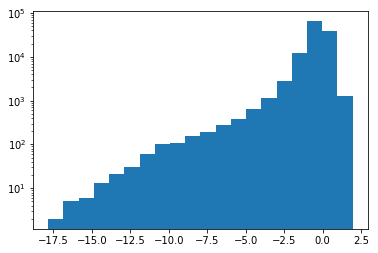

In [144]:
plt.figure()
plt.hist(predictions,bins=20)
plt.yscale('log')

In [ ]:
param_gpu_rf={
 'device': 'gpu',
 'gpu_use_dp': True,
 'learning_rate': 0.01,
 'max_depth': -1,
 'metric': 'rmse',
 'nthread': 0,
 'num_leaves': 31,
 'objective': 'regression',
 'random_state': 4950,
 'verbosity': -1}

In [107]:
param_gpu

{'bagging_fraction': 0.9,
 'bagging_freq': 1,
 'bagging_seed': 42,
 'boosting': 'gbdt',
 'device': 'gpu',
 'feature_fraction': 0.9,
 'gpu_use_dp': True,
 'lambda_l1': 0.1,
 'learning_rate': 0.01,
 'max_depth': -1,
 'metric': 'rmse',
 'min_child_samples': 20,
 'min_data_in_leaf': 32,
 'nthread': 0,
 'num_leaves': 31,
 'objective': 'regression',
 'random_state': 4950,
 'verbosity': -1}

In [110]:
param_gpu_goss=param_gpu.copy()
del param_gpu_goss['bagging_fraction'],param_gpu_goss['bagging_freq'],param_gpu_goss['bagging_seed']
param_gpu_goss['boosting']='goss'
predictions,oof, rmse=lgb_oof(param_gpu_goss, df_train,df_train_columns,df_test,verbose=200)

fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 9.20881e+07	valid_1's rmse: 9.13918e+07
[400]	training's rmse: 1.39362e+07	valid_1's rmse: 1.38259e+07
Early stopping, best iteration is:
[100]	training's rmse: 3.64605	valid_1's rmse: 3.70995
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 5.25292e+23	valid_1's rmse: 5.20078e+23
[400]	training's rmse: 7.56395e+22	valid_1's rmse: 7.59935e+22
Early stopping, best iteration is:
[100]	training's rmse: 3.6447	valid_1's rmse: 3.71662
fold: 2
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.63117e+10	valid_1's rmse: 3.63146e+10
[400]	training's rmse: 5.10151e+09	valid_1's rmse: 5.04836e+09
Early stopping, best iteration is:
[100]	training's rmse: 3.64303	valid_1's rmse: 3.72341
fold: 3
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 39724.9	valid_1's rmse: 39838.8
[400]	training

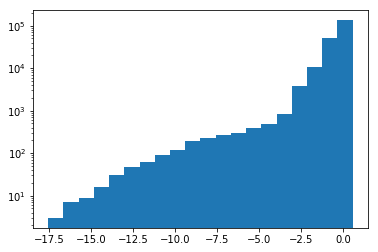

In [103]:
plt.figure()
plt.hist(oof,bins=20)
plt.yscale('log')

# Let's upload Kim's results

In [149]:
df_train_kim=pd.read_csv('../Kim solution/train_kim.csv')
df_test_kim=pd.read_csv('../Kim solution/test_kim.csv')

In [153]:
exclude_features = []
exclude_features += ['card_id', 'first_active_month','target','outliers']
df_train_columns_kim = [c for c in df_train_kim.columns if c not in exclude_features ]
target = df_train['target']
# del df_train['target']

In [159]:
df_train_columns_ku=[]
for feat in df_train_columns_kim:
    if feat not in df_train_columns:
        df_train_columns_ku.append(feat)
        
        
        

In [161]:
len(df_train_columns_ku)

89

In [166]:
columns_all=df_train_columns+df_train_columns_ku
len(columns_all)

354

In [164]:
df_train_all=df_train.join(df_train_kim[df_train_columns_ku])
df_test_all=df_test.join(df_test_kim[df_train_columns_ku])

In [167]:
predictions,oof, rmse=lgb_oof(param, df_train_all,columns_all,df_test_all,verbose=200)

fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.53696	valid_1's rmse: 3.66663
[400]	training's rmse: 3.43634	valid_1's rmse: 3.64941
[600]	training's rmse: 3.37286	valid_1's rmse: 3.64568
[800]	training's rmse: 3.32224	valid_1's rmse: 3.64488
[1000]	training's rmse: 3.27711	valid_1's rmse: 3.64429
[1200]	training's rmse: 3.23719	valid_1's rmse: 3.6452
Early stopping, best iteration is:
[935]	training's rmse: 3.29154	valid_1's rmse: 3.64399
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.53377	valid_1's rmse: 3.6734
[400]	training's rmse: 3.43008	valid_1's rmse: 3.65287
[600]	training's rmse: 3.36619	valid_1's rmse: 3.64679
[800]	training's rmse: 3.31651	valid_1's rmse: 3.64537
[1000]	training's rmse: 3.27362	valid_1's rmse: 3.64481
[1200]	training's rmse: 3.23347	valid_1's rmse: 3.64485
[1400]	training's rmse: 3.19638	valid_1's rmse: 3.64565
Early stopping, best iteration is:
[1037]	training

In [168]:
#LB:3.743
submission('wang_kim_combined.csv',predictions)

wang_kim_combined.csv file saved


In [169]:
predictions,oof, rmse=lgb_oof(param, df_train_all,df_train_columns_kim,df_test_all,verbose=200)

fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55934	valid_1's rmse: 3.66117
[400]	training's rmse: 3.47324	valid_1's rmse: 3.64307
[600]	training's rmse: 3.41733	valid_1's rmse: 3.64
[800]	training's rmse: 3.37438	valid_1's rmse: 3.64036
[1000]	training's rmse: 3.33579	valid_1's rmse: 3.64103
Early stopping, best iteration is:
[628]	training's rmse: 3.41153	valid_1's rmse: 3.63965
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55833	valid_1's rmse: 3.66825
[400]	training's rmse: 3.47094	valid_1's rmse: 3.64734
[600]	training's rmse: 3.41415	valid_1's rmse: 3.63968
[800]	training's rmse: 3.37173	valid_1's rmse: 3.63753
[1000]	training's rmse: 3.33416	valid_1's rmse: 3.63606
[1200]	training's rmse: 3.29942	valid_1's rmse: 3.6354
[1400]	training's rmse: 3.26621	valid_1's rmse: 3.63545
[1600]	training's rmse: 3.23542	valid_1's rmse: 3.63465
[1800]	training's rmse: 3.20607	valid_1's rmse: 3.63

In [170]:
#LB:3.771
submission('kim_with_param.csv',predictions)

kim_with_param.csv file saved


# Manual blending of best Adams 3.669 results with my fe_wang elimination

In [189]:
df_adam=pd.read_csv('..\wang_kim13_3.669.csv')

In [191]:
df_fe_wang_mean=pd.read_csv('..\wang_kernel\mean_fe_wang_param.csv')

In [192]:
df_submisi
df_submission['card_id']=df_adam.card_id

NameError: name 'df_submission' is not defined

In [172]:
df_train_all[df_train_columns_kim].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 90 columns):
feature_1                                       201917 non-null int64
feature_2                                       201917 non-null int64
feature_3                                       201917 non-null int64
his_month_lag_min                               201917 non-null int64
tot_ca4_month_lag_min                           193890 non-null float64
his_month_lag_max                               201917 non-null int64
new_month_lag_max                               179986 non-null float64
den_month_lag_max                               170958 non-null float64
tot_ca4_month_lag_max                           193890 non-null float64
tot_ca3_C_month_lag_max                         98577 non-null float64
his_month_lag_mean                              201917 non-null float64
new_month_lag_mean                              179986 non-null float64
his_month_lag_median                

In [180]:
cat_cols = ['feature_1', 'feature_2', 'feature_3', 'category_2', 'category_3', 'state_id'
            , 'subsector_id_rank_1', 'subsector_id_rank_2', 'subsector_id_rank_3'
            , 'city_id', 'merchant_category_id']
cat_cols = [col for col in cat_cols if col in df_train_all.columns]

cat_cols

['feature_1', 'feature_2', 'feature_3', 'category_2', 'subsector_id_rank_1']

In [181]:
for col in cat_cols:
    df_train_all[col].astype('category')
    df_test_all[col].astype('category')


In [188]:
predictions,oof, rmse=lgb_oof(param, df_train_all,df_train_columns_kim,df_test_all,verbose=200)

fold: 0
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55934	valid_1's rmse: 3.66117
[400]	training's rmse: 3.47324	valid_1's rmse: 3.64307
[600]	training's rmse: 3.41733	valid_1's rmse: 3.64
[800]	training's rmse: 3.37438	valid_1's rmse: 3.64036
[1000]	training's rmse: 3.33579	valid_1's rmse: 3.64103
Early stopping, best iteration is:
[628]	training's rmse: 3.41153	valid_1's rmse: 3.63965
fold: 1
Training until validation scores don't improve for 400 rounds.
[200]	training's rmse: 3.55833	valid_1's rmse: 3.66825
[400]	training's rmse: 3.47094	valid_1's rmse: 3.64734
[600]	training's rmse: 3.41415	valid_1's rmse: 3.63968
[800]	training's rmse: 3.37173	valid_1's rmse: 3.63753
[1000]	training's rmse: 3.33416	valid_1's rmse: 3.63606
[1200]	training's rmse: 3.29942	valid_1's rmse: 3.6354
[1400]	training's rmse: 3.26621	valid_1's rmse: 3.63545
[1600]	training's rmse: 3.23542	valid_1's rmse: 3.63465
[1800]	training's rmse: 3.20607	valid_1's rmse: 3.63